## K-Nearest Neighbors (KNN) Classifier on Toy dataset

Basic Formulas

In [1]:
import numpy as np
from scipy.spatial import distance

# Sample data
X1 = np.array([1, 2, 3])
X2 = np.array([4, 5, 6])

# Euclidean Distance (L2)
euclidean = np.sqrt(np.sum((X1 - X2)**2))
euclidean_scipy = distance.euclidean(X1, X2)

# Manhattan Distance (L1)
manhattan = np.sum(np.abs(X1 - X2))
manhattan_scipy = distance.cityblock(X1, X2)

# Minkowski Distance (generalized)
def minkowski_distance(x1, x2, p):
    return np.sum(np.abs(x1 - x2)**p)**(1/p)

minkowski_2 = minkowski_distance(X1, X2, 2)  # Euclidean
minkowski_1 = minkowski_distance(X1, X2, 1)  # Manhattan

print(f"Euclidean: {euclidean:.2f}")
print(f"Manhattan: {manhattan:.2f}")
print(f"Minkowski (p=2): {minkowski_2:.2f}")

Euclidean: 5.20
Manhattan: 9.00
Minkowski (p=2): 5.20


## KNN Classifier on Toy Dataset Demo

1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score, precision_recall_curve
)


2. Load Dataset

In [3]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# 0 = malignant (cancer), 1 = benign (no cancer)
print(data.target_names)


['malignant' 'benign']


3. Initial Exploration

In [4]:
print(X.shape)
X.head()

print("\nClass distribution:")
print(pd.Series(y).value_counts())


(569, 30)

Class distribution:
1    357
0    212
Name: count, dtype: int64


4. Preprocessing: Why Scaling Matters in KNN

KNN uses distance (e.g., Euclidean), so features must be scaled to prevent dominance by large-scale features.

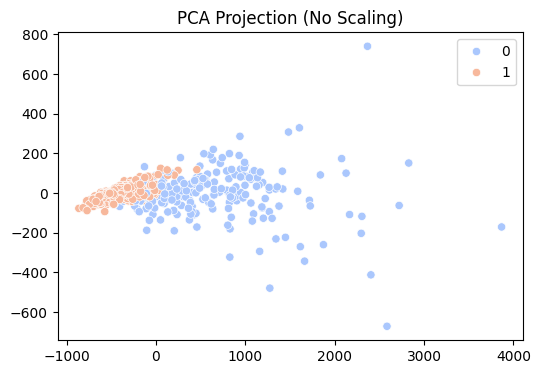

In [5]:
from sklearn.decomposition import PCA

# Without scaling (not ideal)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm')
plt.title("PCA Projection (No Scaling)")
plt.show()


We’ll handle scaling properly using Pipeline.

5. KNN Concepts & Core Math

| Concept                     | Description                                                              |
| --------------------------- | ------------------------------------------------------------------------ |
| **KNN Classifier**          | Predicts class by majority vote from k nearest points                    |
| **Distance metrics**        | Measures "closeness". Default is Euclidean. Others: Manhattan, Minkowski |
| **Scaling**                 | Essential! All features must contribute equally to distance              |
| **Weighted voting**         | `weights='distance'` makes closer neighbors more influential             |
| **Curse of Dimensionality** | As dimensions increase, all distances become similar → bad for KNN       |


6. Build a Pipeline: StandardScaler + KNN

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


7. Hyperparameter Tuning – GridSearchCV

- We’ll tune:
    - n_neighbors (odd values to avoid ties)
    - weights ('uniform' vs 'distance')
    - metric (distance function)
    - p (Minkowski parameter: 1 = Manhattan, 2 = Euclidean)

In [7]:
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski'],
    'knn__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid.fit(X, y)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'knn__metric': 'minkowski', 'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'}


8. Split Data and Train Final Model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

best_knn = grid.best_estimator_
best_knn.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('knn', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",7
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30


9. Evaluation Metrics

a. Confusion Matrix

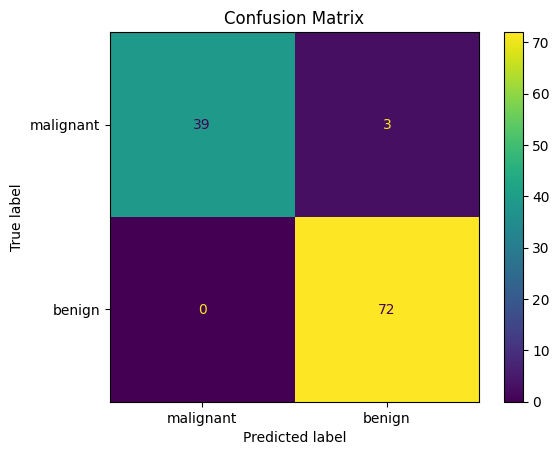


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       0.96      1.00      0.98        72

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [9]:
y_pred = best_knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


b. ROC Curve

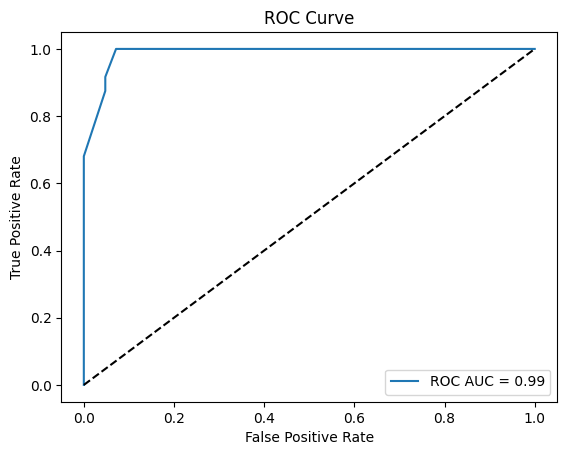

In [10]:
y_probs = best_knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


c. Precision-Recall Curve

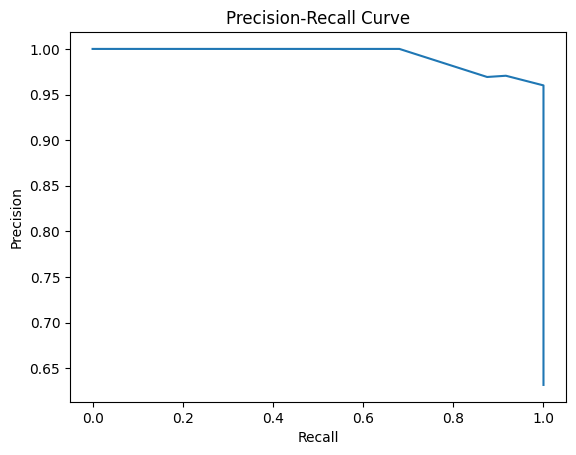

In [11]:
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

10. Class Imbalance Handling (Optional)

Check imbalance:

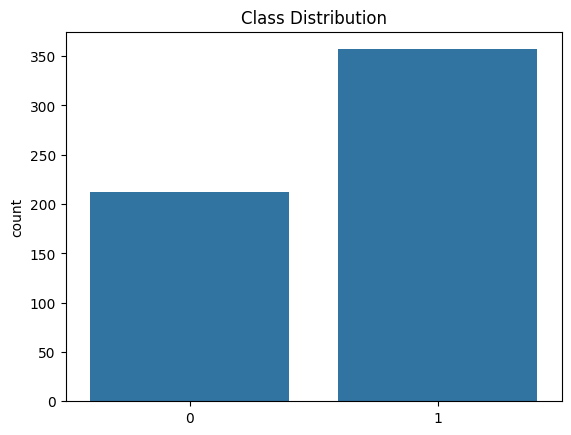

In [12]:
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()

- Strategies:
    - Use class_weight='balanced' in some classifiers (not available in KNN directly)
    - Try resampling techniques (e.g., SMOTE or undersampling)

### KNN Hyperparameters

| Hyperparameter | Description                                          | Tip                                          | Example Values                              |
| -------------- | ---------------------------------------------------- | -------------------------------------------- | ------------------------------------------- |
| `n_neighbors`  | Number of neighbors to consider                      | Use odd values to avoid ties                 | 3, 5, 7, 9                                  |
| `weights`      | Voting strategy: all equal or weighted               | Try `'distance'` if close points matter more | `'uniform'`, `'distance'`                   |
| `metric`       | Distance function                                    | `'minkowski'` (default)                      | `'minkowski'`, `'euclidean'`, `'manhattan'` |
| `p`            | Power for Minkowski (p=2: Euclidean, p=1: Manhattan) | Try both                                     | 1, 2                                        |
